In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from reweight_functions import *
import pickle

In [3]:
pwd

'/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Tau'

In [4]:
main_path = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Tau/'

outdir = os.path.join(main_path, 'reweight_trial')
datadir = main_path
expdatadir = main_path
weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)

In [5]:
chemical_shifts = ['CB', 'CA', 'H', 'N', 'C']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'CD': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

reweighting_keys = ['CA', 'C', 'CD']
theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1., 'CD': 1.}

to_remove = ['HA','HA2', 'HA3', 'CB', 'H', 'N']

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))

Main settings:

Reweighting keys: ['CA', 'C', 'CD']


In [6]:
# chemical shifts
expdata = read_exp_cs(join(expdatadir, 'CS.exp.dat'))
compdata = read_cs_md(join(datadir, 'cs_assignment.csv'), )



In [7]:
def adjust_and_clean_keys(nested_dict, add_value=390, keys_to_remove=['390', '447']):
    new_dict = {}
    for shift_type, shifts in nested_dict.items():
        adjusted_shifts = {str(int(k) + add_value): v for k, v in shifts.items()}
        # Remove specified keys
        for key in keys_to_remove:
            if key in adjusted_shifts:
                del adjusted_shifts[key]
        new_dict[shift_type] = adjusted_shifts
    return new_dict

def Align_Comp_Exp_Data(compdata, expdata):
    # Adjust and clean keys in compdata only
    compdata = adjust_and_clean_keys(compdata)

    for data1, data1_t in zip([compdata, expdata], ['comp', 'exp']):
        data2 = expdata if data1_t == 'comp' else compdata
        to_align = {}
        for key1 in data1.keys():
            to_align[key1] = []
            for key2 in data1[key1].keys():
                if key2 not in data2[key1].keys() or data1[key1][key2][0] == 0.0:
                    to_align[key1].append(key2)

        for key1 in to_align.keys():
            for key2 in to_align[key1]:
                if key2 in data1[key1].keys():
                    data1[key1].pop(key2)
                if key2 in data2[key1].keys():
                    data2[key1].pop(key2)
                  
    return compdata, expdata

In [8]:
# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)

#CD spectra
expdata = add_exp_data(join(expdatadir, 'CD.exp.dat'), expdata, 'CD')
compdata = add_md_data(join(datadir, 'CD.csv'), compdata, 'CD')

def convert_keys_to_str(d):
    new_dict = {}
    for key, value in d.items():
        # Convert the key to float to remove trailing zeros
        new_key = float(key)
        # Convert the float key back to string
        new_key_str = str(new_key)
        # Add the new key-value pair to the new dictionary
        new_dict[new_key_str] = value
    return new_dict

# Apply the function to the 'CD' key
compdata['CD'] = convert_keys_to_str(compdata['CD'])
expdata['CD'] = convert_keys_to_str(expdata['CD'])
####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])
# nframes = len(compdata['Rg'][0])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'CD']
Number of frames = 3007


In [9]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['C', 'CD']
C
CD
CA
Reweight Data = C
Validation Data = ['CA', 'CD']
CA
CD
C
Reweight Data = CD
Validation Data = ['CA', 'C']
CA
C
CD


In [10]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = C
Reweight Data = CD


In [11]:
kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)

In [12]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


In [13]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()


Reweight Data = CA
1.01
CA Theta: 1.005974874371859 Kish: 12.623420 RMSD initail: 0.4572 RMSD final: 0.1963
Initial RMSE reweight data 
 * Total :      0.457
 *    CA :      0.457
Initial RMSE validation data
 * Total :      1.894
 *     C :      0.447
 *    CD :      1.980
Final RMSE reweight data
 * Total :      0.196
 *    CA :      0.196
Final RMSE validation data
 * Total :      2.047
 *     C :      0.357
 *    CD :      2.142
Reweight Data = C
1.01
C Theta: 1.005974874371859 Kish: 13.412454 RMSD initail: 0.4474 RMSD final: 0.2431
Initial RMSE reweight data 
 * Total :      0.447
 *     C :      0.447
Initial RMSE validation data
 * Total :      1.894
 *    CA :      0.457
 *    CD :      1.980
Final RMSE reweight data
 * Total :      0.243
 *     C :      0.243
Final RMSE validation data
 * Total :      1.723
 *    CA :      0.364
 *    CD :      1.802
Reweight Data = CD
12.66
CD Theta: 12.663683417085426 Kish: 10.042822 RMSD initail: 1.9800 RMSD final: 1.2635
Initial RMSE rewei

In [14]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        sigma_md = sigma_md_r
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'C', 'CD']]
Reweight Data = CA-C-CD
20.00
18.95
17.90
16.84
15.79
14.74
13.69
12.64
11.58
10.53
9.48
8.43
7.37
6.32
5.27
4.22
3.17
2.11
1.06
0.01


In [15]:
kish_min = 10
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-C-CD 2.114210526315789


In [16]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

In [28]:
from matplotlib.ticker import StrMethodFormatter
exp_CD = np.loadtxt('/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Tau/CD.exp.dat')
def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='blue', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('WT CD v predict.png', bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

<span style="font-size:larger;">THIS IS PLOTTING THE FIT AFTER REWEIGHTING WITH ALL THE DATA (CA, C AND CD SPECTRA)</span>


CA
RMSD_initial: 0.457 RMSD_final: 0.190


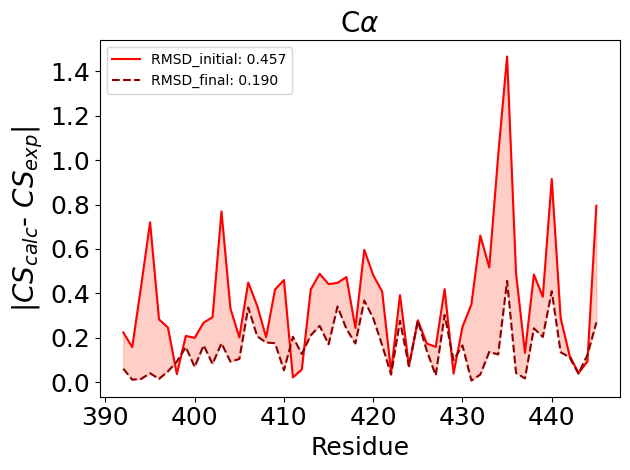

C
RMSD_initial: 0.447 RMSD_final: 0.254


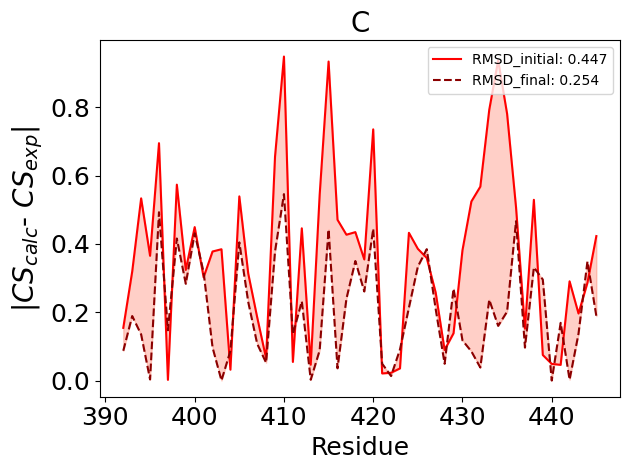

CD
RMSD_initial: 1.980 RMSD_final: 1.328


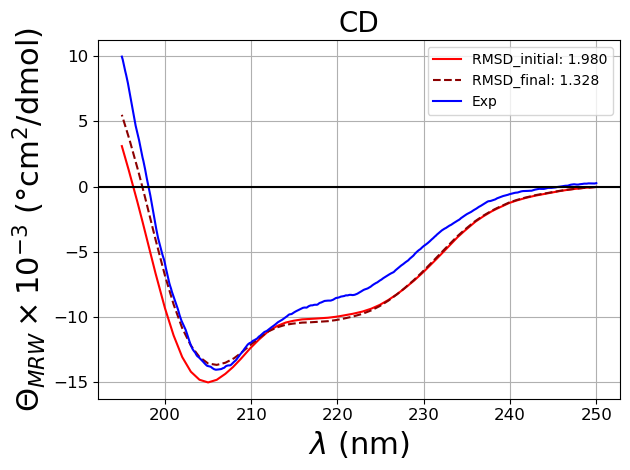

CA-C-CD Theta: 1.0621052631578947 Kish:  2.254336 RMSD initail: 1.8197 RMSD final: 1.2174
Initial RMSE reweight data 
 * Total :      1.820
 *    CA :      0.457
 *     C :      0.447
 *    CD :      1.980
Final RMSE reweight data
 * Total :      1.217
 *    CA :      0.190
 *     C :      0.254
 *    CD :      1.328


In [29]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
sigma_md=sigma_md_r
        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

In [19]:
new_rwt_keys = [['CA', 'C'],'CD']

In [20]:
To_Scan = new_rwt_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_leave_one_dict = {}
KishScan_leave_one_out = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_leave_one_out[CS] = {}
    print('Reweight Data = {}'.format(CS))
    RMSE_leave_one_dict[CS] = {}

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        sigma_reg = theta_m * err_r
        sigma_md = sigma_md_r
        RMSE_leave_one_dict[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)

        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        if 'RDC' in Validation_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)
            exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_v_type['RDC'] == 1)
            traj_v[RDC_rows] = traj_v[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)

        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        final_obs_r = np.dot(traj_r, final_weights)
        final_obs_v = np.dot(traj_v, final_weights)
        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_v_i = {}
        RMSE_r_f = {}
        RMSE_v_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_v_i['Tot'] = np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
        for t in data_v_type:
            RMSE_v_i[t] = np.sqrt(
                np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        for t in data_v_type:
            RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_f['RDC'] = qf

        RMSE_leave_one_dict[CS][s]['Kish'] = Kish_ratio
        RMSE_leave_one_dict[CS][s]['r_i'] = RMSE_r_i
        RMSE_leave_one_dict[CS][s]['r_f'] = RMSE_r_f
        RMSE_leave_one_dict[CS][s]['v_i'] = RMSE_v_i
        RMSE_leave_one_dict[CS][s]['v_f'] = RMSE_v_f

    KishScan_leave_one_out[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_leave_one_out[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA-C
Reweight Data = CD


In [21]:
kish_min = 10
theta_dict_leave_one = {}
Kish_ratio_vals = []
for key in KishScan_leave_one_out:
    k = KishScan_leave_one_out[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_leave_one[key] = {}
    theta_dict_leave_one[key] = (theta_m)

In [30]:
def plot_fitting_validate_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='blue', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()
                
    for t in Validation_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_v[t]):
                resid.append(float(id))
                exp.append(compare_dict_v[t][id][0])
                
            initial = np.trim_zeros(initial_obs_v * data_v_type[t])
            reweight = np.trim_zeros(final_obs_v * data_v_type[t])
            exp = np.trim_zeros(obs_exp_v * data_v_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='blue', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

<span style="font-size:larger;">FIRST THREE PLOTS ARE AFTER REWEIGHTING WITH CA AND C (CD PLOT IS CROSS-VALIDATION). LAST THREE PLOTS ARE AFTER REWEIGHTING WITH CD SPECTRA (CA AND C PLOTS ARE CROSS-VALIDATION)</span>


Reweight Data = CA-C
2.11
CA
RMSD_initial: 0.457 RMSD_final: 0.302


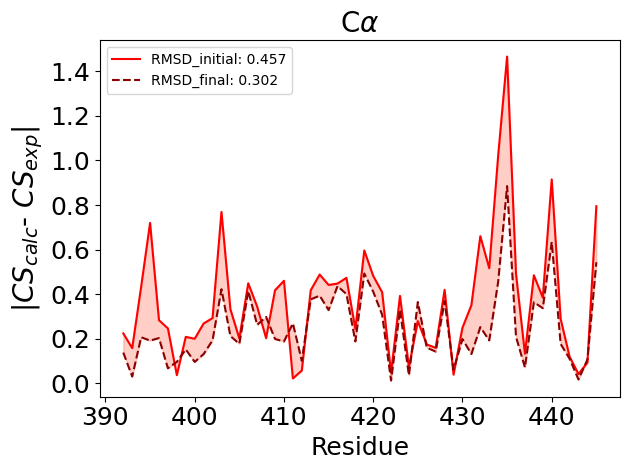

C
RMSD_initial: 0.447 RMSD_final: 0.333


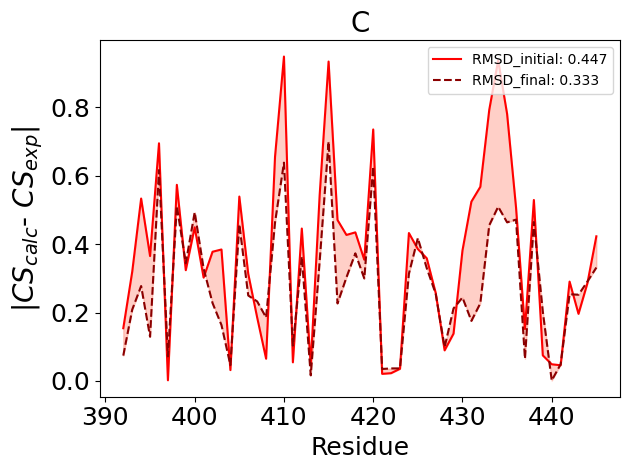

CD
RMSD_initial: 1.980 RMSD_final: 2.007


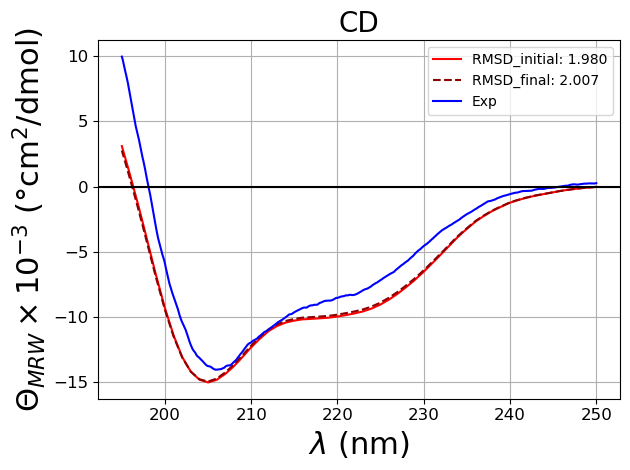

CA-C Theta: 2.114210526315789 Kish: 42.021037 RMSD initail: 0.4523 RMSD final: 0.3177
Initial RMSE reweight data 
 * Total :      0.452
 *    CA :      0.457
 *     C :      0.447
Initial RMSE validation data
 * Total :      1.980
 *    CD :      1.980
Final RMSE reweight data
 * Total :      0.318
 *    CA :      0.302
 *     C :      0.333
Final RMSE validation data
 * Total :      2.007
 *    CD :      2.007
Reweight Data = CD
1.06
CD
RMSD_initial: 1.980 RMSD_final: 1.286


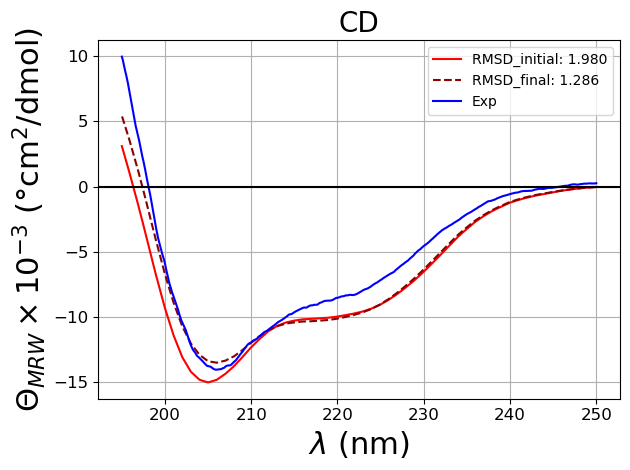

CA
RMSD_initial: 0.457 RMSD_final: 0.433


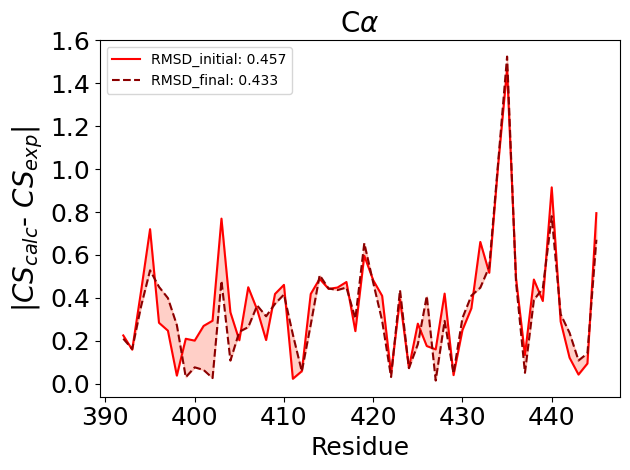

C
RMSD_initial: 0.447 RMSD_final: 0.465


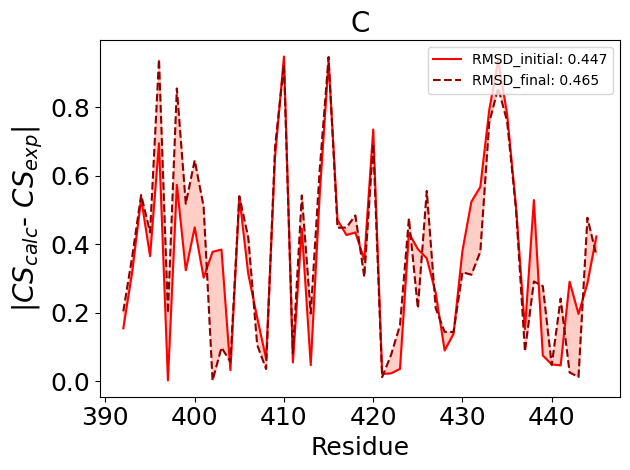

CD Theta: 1.0621052631578947 Kish: 11.658605 RMSD initail: 1.9800 RMSD final: 1.2863
Initial RMSE reweight data 
 * Total :      1.980
 *    CD :      1.980
Initial RMSE validation data
 * Total :      0.452
 *    CA :      0.457
 *     C :      0.447
Final RMSE reweight data
 * Total :      1.286
 *    CD :      1.286
Final RMSE validation data
 * Total :      0.449
 *    CA :      0.433
 *     C :      0.465


In [32]:
To_Scan = new_rwt_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(leave_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict_leave_one[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m * err_r
    sigma_md = sigma_md_r

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    # if res.success: print("\nMinimization worked: {}\n".format(res.success))
    # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    # print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
    # print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

    plot_fitting_validate_data(final_weights)
    
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        # (initial_obs_v-obs_exp_v)**2*data_v_type[t])
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()